In [1]:
import missingno as msno
from sklearn.model_selection import train_test_split
from scipy import stats
import re
pd.options.display.float_format = '{:.2f}'.format
# 지수 표기법 해제

In [2]:
raw_data = pd.read_csv("vehicles.csv")

# 컬럼별 결측치 비율

In [3]:
def columns_na_percentage(columns):
    for col_name in columns:
        print("{} : ".format(col_name),round(100 -(len(raw_data['{}'.format(col_name)].dropna()) / len(raw_data)) * 100,4),"%", end='\n')

In [4]:
columns_na_percentage(raw_data.columns)

id :  0.0 %
url :  0.0 %
region :  0.0 %
region_url :  0.0 %
price :  0.0 %
year :  0.2997 %
manufacturer :  4.4672 %
model :  1.5678 %
condition :  45.515 %
cylinders :  39.186 %
fuel :  0.782 %
odometer :  18.1178 %
title_status :  0.6009 %
transmission :  0.7298 %
vin :  40.7053 %
drive :  28.2868 %
size :  67.1151 %
type :  27.7742 %
paint_color :  32.3221 %
image_url :  0.0027 %
description :  0.0031 %
county :  100.0 %
state :  0.0 %
lat :  2.0197 %
long :  2.0197 %


### 제외 컬럼
- 텍스트 데이터
  - 'url','region_url','vin','image_url','description'
- 위치정보
  - 'lat','long'
 
- 주관적 데이터
  - condition
- 기타
  - 'model' : 카테고리 너무 많음
  - 'county' : 전부 null
  - 'id;
  - 'size' : 결측치 50% 이상

In [5]:
start_df = raw_data[['id','price','year','cylinders','drive','fuel','manufacturer','odometer','state','title_status','transmission','type','paint_color']]

In [6]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 13 columns):
id              509577 non-null int64
price           509577 non-null int64
year            508050 non-null float64
cylinders       309894 non-null object
drive           365434 non-null object
fuel            505592 non-null object
manufacturer    486813 non-null object
odometer        417253 non-null float64
state           509577 non-null object
title_status    506515 non-null object
transmission    505858 non-null object
type            368046 non-null object
paint_color     344871 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 50.5+ MB


# 데이터 전처리

In [7]:
# 종속변수
# 0, 100불 이하, 100만불 초과 삭제
df = start_df[(start_df['price'] >= 100) & (start_df['price'] < 1000000) & (start_df['price'] != 0)]

print("="*100)
print("0, 100불 이하, 100만불 초과 삭제 후", end="\n")          
print(len(df))

# 이상치 제거
n = ""
for j in range(1,10):
    root_num = float(str(1)*j)
    for i in range(1,10):
        df = df[df['price'] != root_num * i]

for k in range(1,10):
    k = str(k)
    n += k
    df = df[df['price'] != float(k)]

for m in range(1,9):
    df = df[df['price'] != float(n[m:])]


print("="*100)
print("이상치 제거 후", end="\n")          
print(len(df))


# 독립변수 
# 2020, 2021, 결측치 삭제
df = df[(df['year'] != 2021) & (df['year'] != 2020) & (df['year'] != 0) & (df['year'].notnull())]

print("="*100)
print("2020, 2021, 결측치 삭제 후", end="\n")          
print(len(df))

# 주행거리 0, 100 이하, 1000000만 이상, 결측치 삭제
df = df[(df["odometer"] != 0) & (df["odometer"].notnull()) & (df["odometer"] >= 100) & (df["odometer"] <= 1000000)]

print("="*100)
print("주행거리 0, 100 이하, 1000000만 이상, 결측치 삭제 후", end="\n")        
print(len(df))

# 결측치 제거
print("="*100)    
print("독립변수 결측치 제거")
for i in df.columns:
    df = df[df[i].notnull()]
    
    print(i," : ",len(df),end='\n')

print("="*100)    
print("최종 제거 후", end="\n")
print(len(df))

0, 100불 이하, 100만불 초과 삭제 후
461658
이상치 제거 후
459129
2020, 2021, 결측치 삭제 후
456693
주행거리 0, 100 이하, 1000000만 이상, 결측치 삭제 후
373136
독립변수 결측치 제거
id  :  373136
price  :  373136
year  :  373136
cylinders  :  246736
drive  :  223058
fuel  :  221024
manufacturer  :  213715
odometer  :  213715
state  :  213715
title_status  :  212656
transmission  :  212631
type  :  190501
paint_color  :  169949
최종 제거 후
169949


In [14]:
msno.matrix(df)

In [15]:
# 연도를 int로 변환
df['year'] = df['year'].astype("int")

In [9]:
df = df[df.columns.difference(['cylinders'])]

In [10]:
len(df)

169949

In [11]:
# 원래  : 0.562, 169949 rows
# cylinders, paint_color 제거  : 0.568, 190501 rows
# paint_color 제거 : 0.568, 190501 rows
# cylinders 제거 : 

In [17]:
df.columns

Index(['drive', 'fuel', 'id', 'manufacturer', 'odometer', 'paint_color',
       'price', 'state', 'title_status', 'transmission', 'type', 'year'],
      dtype='object')

In [19]:
# cylinder 빼고 돌린것

In [18]:
model = sm.OLS.from_formula("scale(price) ~ scale(year) + scale(odometer) +  C(drive) + C(fuel) + C(manufacturer) +   C(title_status) +  C(transmission) +  C(type) + C(state) + C(paint_color)",df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           scale(price)   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1575.
Date:                Sat, 21 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:05:18   Log-Likelihood:            -1.7393e+05
No. Observations:              169949   AIC:                         3.481e+05
Df Residuals:                  169818   BIC:                         3.494e+05
Df Model:                         130                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

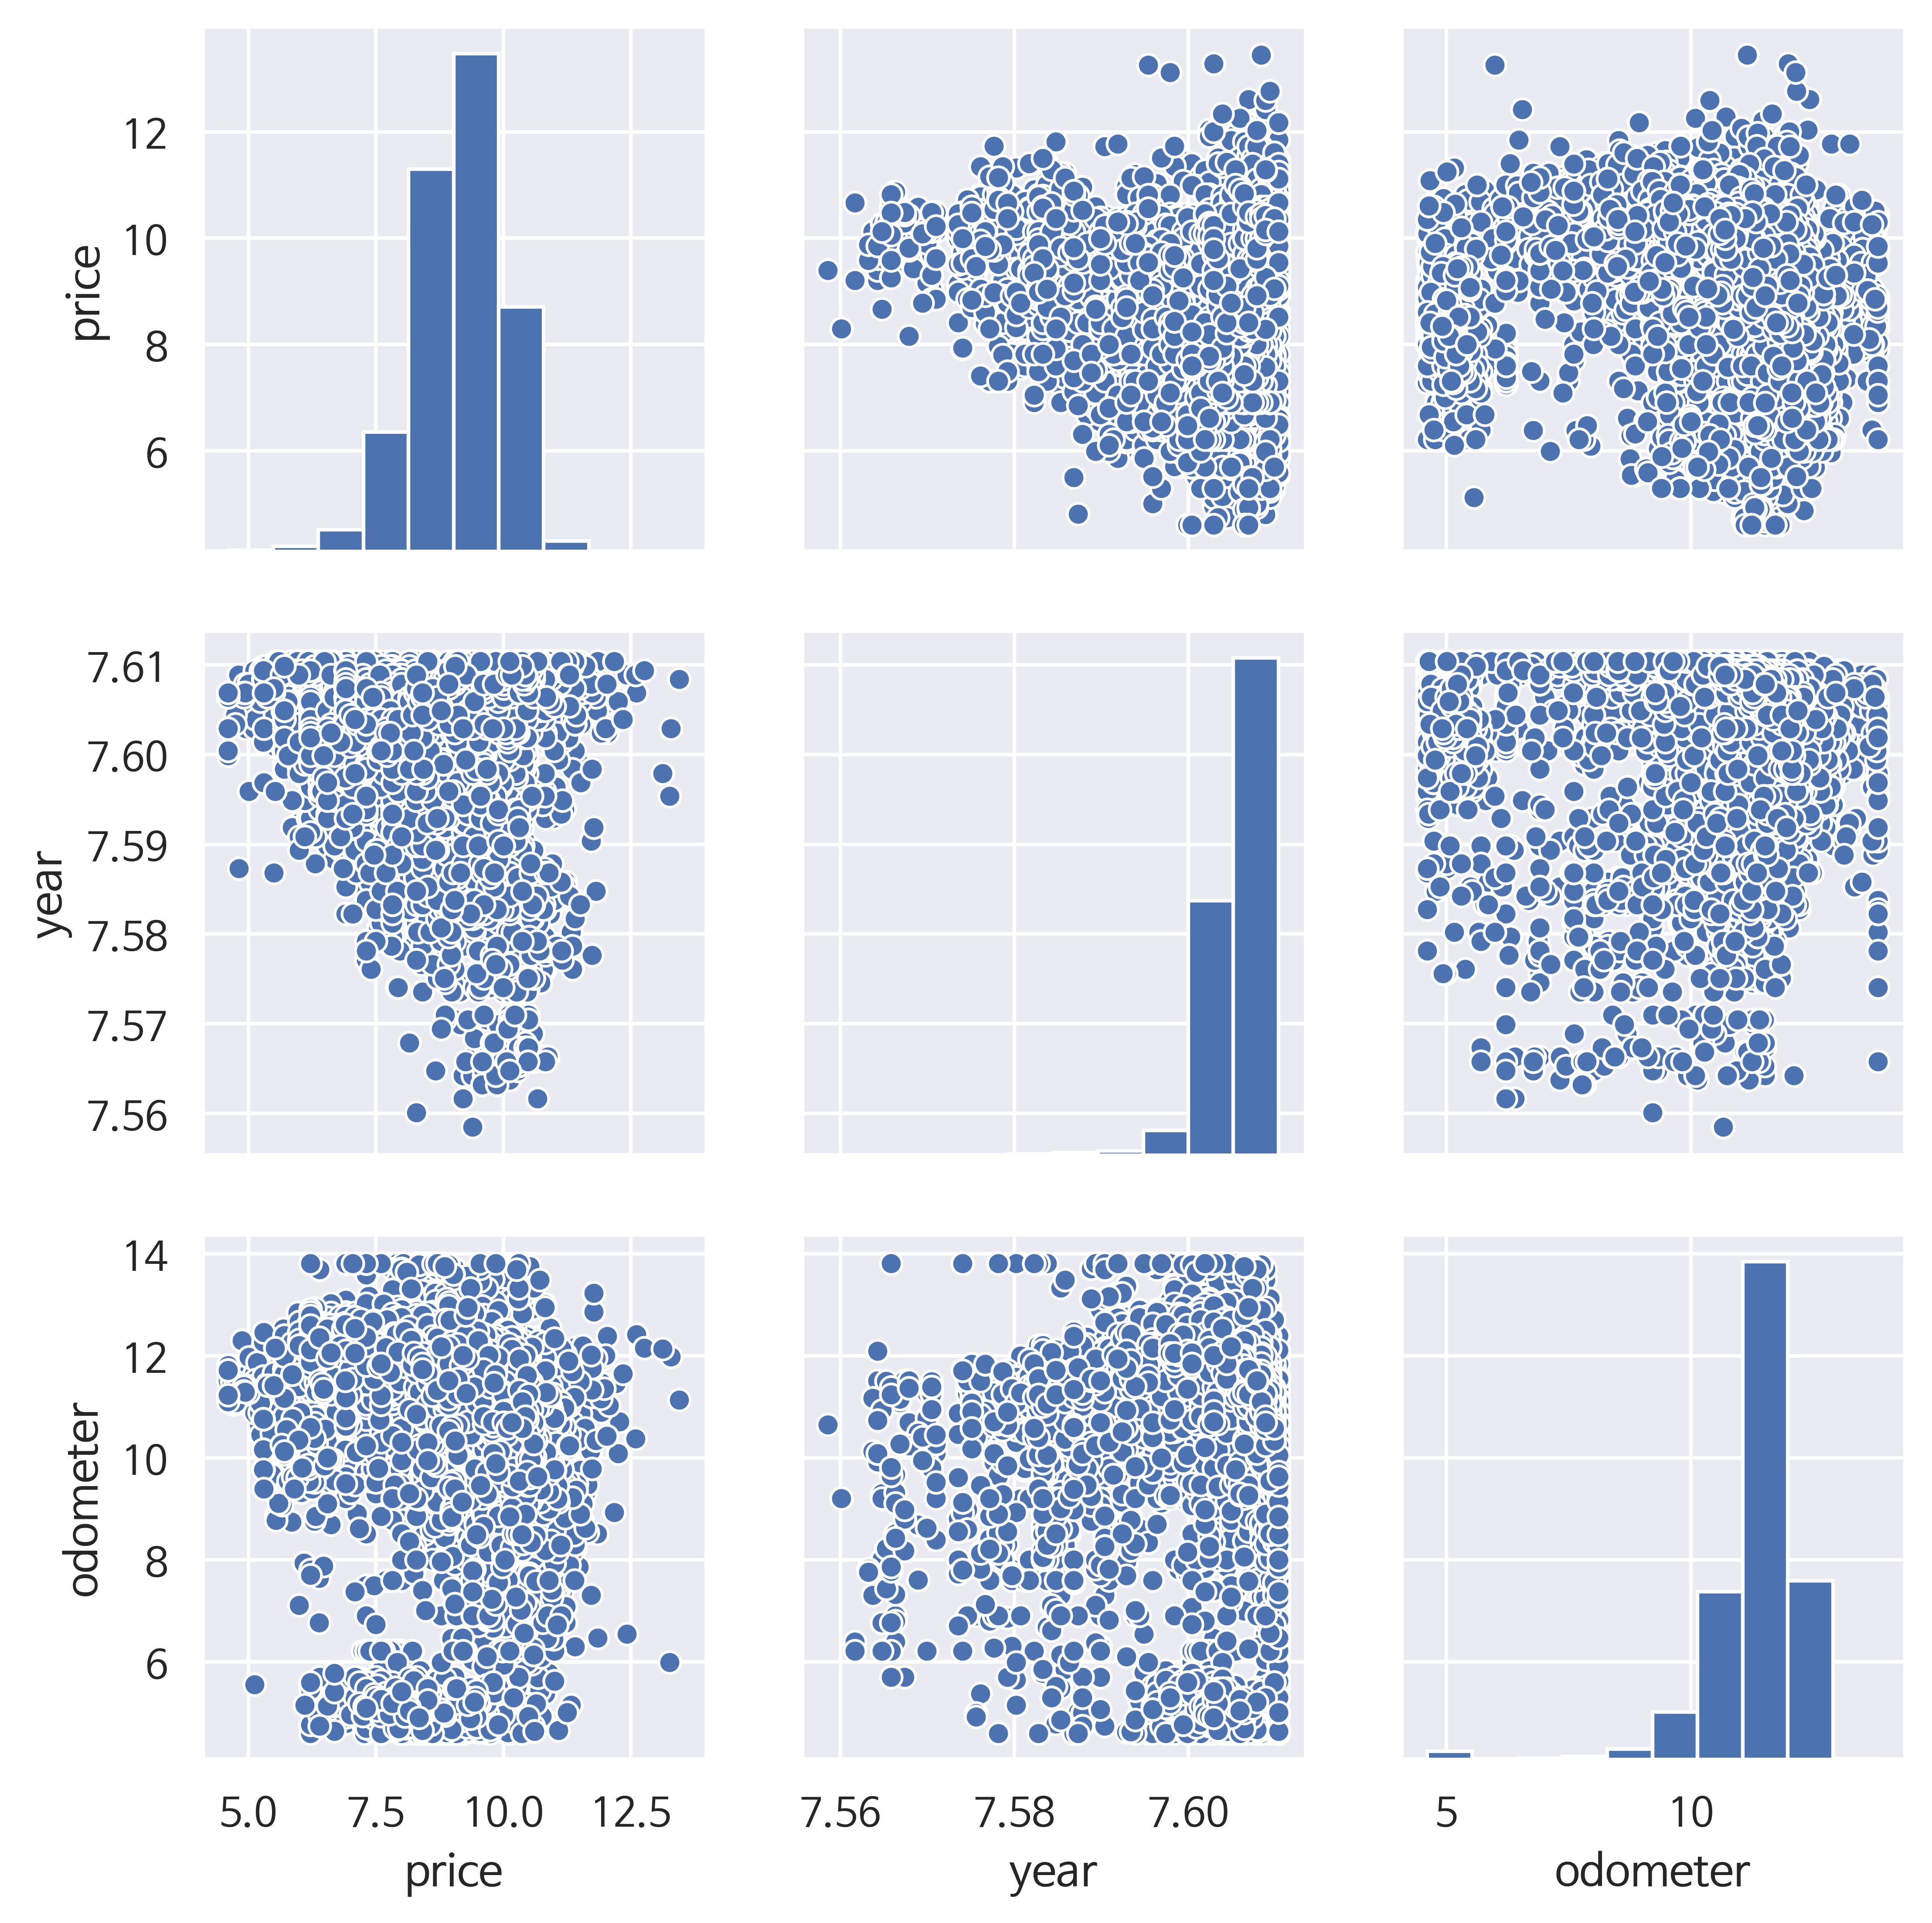

In [20]:
sns.pairplot(np.log(df[['price','year','odometer']]))
plt.show()